## Dependencies

In [1]:
import json, warnings, shutil
from tweet_utility_scripts import *
from tweet_utility_preprocess_roberta_scripts import *
from transformers import TFRobertaModel, RobertaConfig
from tokenizers import ByteLevelBPETokenizer
from tensorflow.keras.models import Model
from tensorflow.keras import optimizers, metrics, losses, layers
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

SEED = 0
seed_everything(SEED)
warnings.filterwarnings("ignore")

In [2]:
class RectifiedAdam(tf.keras.optimizers.Optimizer):
    """Variant of the Adam optimizer whose adaptive learning rate is rectified
    so as to have a consistent variance.
    It implements the Rectified Adam (a.k.a. RAdam) proposed by
    Liyuan Liu et al. in [On The Variance Of The Adaptive Learning Rate
    And Beyond](https://arxiv.org/pdf/1908.03265v1.pdf).
    Example of usage:
    ```python
    opt = tfa.optimizers.RectifiedAdam(lr=1e-3)
    ```
    Note: `amsgrad` is not described in the original paper. Use it with
          caution.
    RAdam is not a placement of the heuristic warmup, the settings should be
    kept if warmup has already been employed and tuned in the baseline method.
    You can enable warmup by setting `total_steps` and `warmup_proportion`:
    ```python
    opt = tfa.optimizers.RectifiedAdam(
        lr=1e-3,
        total_steps=10000,
        warmup_proportion=0.1,
        min_lr=1e-5,
    )
    ```
    In the above example, the learning rate will increase linearly
    from 0 to `lr` in 1000 steps, then decrease linearly from `lr` to `min_lr`
    in 9000 steps.
    Lookahead, proposed by Michael R. Zhang et.al in the paper
    [Lookahead Optimizer: k steps forward, 1 step back]
    (https://arxiv.org/abs/1907.08610v1), can be integrated with RAdam,
    which is announced by Less Wright and the new combined optimizer can also
    be called "Ranger". The mechanism can be enabled by using the lookahead
    wrapper. For example:
    ```python
    radam = tfa.optimizers.RectifiedAdam()
    ranger = tfa.optimizers.Lookahead(radam, sync_period=6, slow_step_size=0.5)
    ```
    """

    def __init__(self,
                 learning_rate=0.001,
                 beta_1=0.9,
                 beta_2=0.999,
                 epsilon=1e-7,
                 weight_decay=0.,
                 amsgrad=False,
                 sma_threshold=5.0,
                 total_steps=0,
                 warmup_proportion=0.1,
                 min_lr=0.,
                 name='RectifiedAdam',
                 **kwargs):
        r"""Construct a new RAdam optimizer.
        Args:
            learning_rate: A `Tensor` or a floating point value. or a schedule
                that is a `tf.keras.optimizers.schedules.LearningRateSchedule`
                The learning rate.
            beta_1: A float value or a constant float tensor.
                The exponential decay rate for the 1st moment estimates.
            beta_2: A float value or a constant float tensor.
                The exponential decay rate for the 2nd moment estimates.
            epsilon: A small constant for numerical stability.
            weight_decay: A floating point value. Weight decay for each param.
            amsgrad: boolean. Whether to apply AMSGrad variant of this
                algorithm from the paper "On the Convergence of Adam and
                beyond".
            sma_threshold. A float value.
                The threshold for simple mean average.
            total_steps: An integer. Total number of training steps.
                Enable warmup by setting a positive value.
            warmup_proportion: A floating point value.
                The proportion of increasing steps.
            min_lr: A floating point value. Minimum learning rate after warmup.
            name: Optional name for the operations created when applying
                gradients. Defaults to "RectifiedAdam".
            **kwargs: keyword arguments. Allowed to be {`clipnorm`,
                `clipvalue`, `lr`, `decay`}. `clipnorm` is clip gradients
                by norm; `clipvalue` is clip gradients by value, `decay` is
                included for backward compatibility to allow time inverse
                decay of learning rate. `lr` is included for backward
                compatibility, recommended to use `learning_rate` instead.
        """
        super(RectifiedAdam, self).__init__(name, **kwargs)
        self._set_hyper('learning_rate', kwargs.get('lr', learning_rate))
        self._set_hyper('beta_1', beta_1)
        self._set_hyper('beta_2', beta_2)
        self._set_hyper('decay', self._initial_decay)
        self._set_hyper('weight_decay', weight_decay)
        self._set_hyper('sma_threshold', sma_threshold)
        self._set_hyper('total_steps', float(total_steps))
        self._set_hyper('warmup_proportion', warmup_proportion)
        self._set_hyper('min_lr', min_lr)
        self.epsilon = epsilon or tf.keras.backend.epsilon()
        self.amsgrad = amsgrad
        self._initial_weight_decay = weight_decay
        self._initial_total_steps = total_steps

    def _create_slots(self, var_list):
        for var in var_list:
            self.add_slot(var, 'm')
        for var in var_list:
            self.add_slot(var, 'v')
        if self.amsgrad:
            for var in var_list:
                self.add_slot(var, 'vhat')

    def set_weights(self, weights):
        params = self.weights
        num_vars = int((len(params) - 1) / 2)
        if len(weights) == 3 * num_vars + 1:
            weights = weights[:len(params)]
        super(RectifiedAdam, self).set_weights(weights)

    def _resource_apply_dense(self, grad, var):
        var_dtype = var.dtype.base_dtype
        lr_t = self._decayed_lr(var_dtype)
        m = self.get_slot(var, 'm')
        v = self.get_slot(var, 'v')
        beta_1_t = self._get_hyper('beta_1', var_dtype)
        beta_2_t = self._get_hyper('beta_2', var_dtype)
        epsilon_t = tf.convert_to_tensor(self.epsilon, var_dtype)
        local_step = tf.cast(self.iterations + 1, var_dtype)
        beta_1_power = tf.pow(beta_1_t, local_step)
        beta_2_power = tf.pow(beta_2_t, local_step)

        if self._initial_total_steps > 0:
            total_steps = self._get_hyper('total_steps', var_dtype)
            warmup_steps = total_steps *\
                self._get_hyper('warmup_proportion', var_dtype)
            min_lr = self._get_hyper('min_lr', var_dtype)
            decay_steps = tf.maximum(total_steps - warmup_steps, 1)
            decay_rate = (min_lr - lr_t) / decay_steps
            lr_t = tf.where(
                local_step <= warmup_steps,
                lr_t * (local_step / warmup_steps),
                lr_t + decay_rate * tf.minimum(local_step - warmup_steps,
                                               decay_steps),
            )

        sma_inf = 2.0 / (1.0 - beta_2_t) - 1.0
        sma_t = sma_inf - 2.0 * local_step * beta_2_power / (
            1.0 - beta_2_power)

        m_t = m.assign(
            beta_1_t * m + (1.0 - beta_1_t) * grad,
            use_locking=self._use_locking)
        m_corr_t = m_t / (1.0 - beta_1_power)

        v_t = v.assign(
            beta_2_t * v + (1.0 - beta_2_t) * tf.square(grad),
            use_locking=self._use_locking)
        if self.amsgrad:
            vhat = self.get_slot(var, 'vhat')
            vhat_t = vhat.assign(
                tf.maximum(vhat, v_t), use_locking=self._use_locking)
            v_corr_t = tf.sqrt(vhat_t / (1.0 - beta_2_power))
        else:
            vhat_t = None
            v_corr_t = tf.sqrt(v_t / (1.0 - beta_2_power))

        r_t = tf.sqrt((sma_t - 4.0) / (sma_inf - 4.0) * (sma_t - 2.0) /
                      (sma_inf - 2.0) * sma_inf / sma_t)

        sma_threshold = self._get_hyper('sma_threshold', var_dtype)
        var_t = tf.where(sma_t >= sma_threshold,
                         r_t * m_corr_t / (v_corr_t + epsilon_t), m_corr_t)

        if self._initial_weight_decay > 0.0:
            var_t += self._get_hyper('weight_decay', var_dtype) * var

        var_update = var.assign_sub(
            lr_t * var_t, use_locking=self._use_locking)

        updates = [var_update, m_t, v_t]
        if self.amsgrad:
            updates.append(vhat_t)
        return tf.group(*updates)

    def _resource_apply_sparse(self, grad, var, indices):
        var_dtype = var.dtype.base_dtype
        lr_t = self._decayed_lr(var_dtype)
        beta_1_t = self._get_hyper('beta_1', var_dtype)
        beta_2_t = self._get_hyper('beta_2', var_dtype)
        epsilon_t = tf.convert_to_tensor(self.epsilon, var_dtype)
        local_step = tf.cast(self.iterations + 1, var_dtype)
        beta_1_power = tf.pow(beta_1_t, local_step)
        beta_2_power = tf.pow(beta_2_t, local_step)

        if self._initial_total_steps > 0:
            total_steps = self._get_hyper('total_steps', var_dtype)
            warmup_steps = total_steps *\
                self._get_hyper('warmup_proportion', var_dtype)
            min_lr = self._get_hyper('min_lr', var_dtype)
            decay_steps = tf.maximum(total_steps - warmup_steps, 1)
            decay_rate = (min_lr - lr_t) / decay_steps
            lr_t = tf.where(
                local_step <= warmup_steps,
                lr_t * (local_step / warmup_steps),
                lr_t + decay_rate * tf.minimum(local_step - warmup_steps,
                                               decay_steps),
            )

        sma_inf = 2.0 / (1.0 - beta_2_t) - 1.0
        sma_t = sma_inf - 2.0 * local_step * beta_2_power / (
            1.0 - beta_2_power)

        m = self.get_slot(var, 'm')
        m_scaled_g_values = grad * (1 - beta_1_t)
        m_t = m.assign(m * beta_1_t, use_locking=self._use_locking)
        with tf.control_dependencies([m_t]):
            m_t = self._resource_scatter_add(m, indices, m_scaled_g_values)
        m_corr_t = m_t / (1.0 - beta_1_power)

        v = self.get_slot(var, 'v')
        v_scaled_g_values = (grad * grad) * (1 - beta_2_t)
        v_t = v.assign(v * beta_2_t, use_locking=self._use_locking)
        with tf.control_dependencies([v_t]):
            v_t = self._resource_scatter_add(v, indices, v_scaled_g_values)

        if self.amsgrad:
            vhat = self.get_slot(var, 'vhat')
            vhat_t = vhat.assign(
                tf.maximum(vhat, v_t), use_locking=self._use_locking)
            v_corr_t = tf.sqrt(vhat_t / (1.0 - beta_2_power))
        else:
            vhat_t = None
            v_corr_t = tf.sqrt(v_t / (1.0 - beta_2_power))

        r_t = tf.sqrt((sma_t - 4.0) / (sma_inf - 4.0) * (sma_t - 2.0) /
                      (sma_inf - 2.0) * sma_inf / sma_t)

        sma_threshold = self._get_hyper('sma_threshold', var_dtype)
        var_t = tf.where(sma_t >= sma_threshold,
                         r_t * m_corr_t / (v_corr_t + epsilon_t), m_corr_t)

        if self._initial_weight_decay > 0.0:
            var_t += self._get_hyper('weight_decay', var_dtype) * var

        with tf.control_dependencies([var_t]):
            var_update = self._resource_scatter_add(
                var, indices, tf.gather(-lr_t * var_t, indices))

        updates = [var_update, m_t, v_t]
        if self.amsgrad:
            updates.append(vhat_t)
        return tf.group(*updates)

    def get_config(self):
        config = super(RectifiedAdam, self).get_config()
        config.update({
            'learning_rate':
            self._serialize_hyperparameter('learning_rate'),
            'beta_1':
            self._serialize_hyperparameter('beta_1'),
            'beta_2':
            self._serialize_hyperparameter('beta_2'),
            'decay':
            self._serialize_hyperparameter('decay'),
            'weight_decay':
            self._serialize_hyperparameter('weight_decay'),
            'sma_threshold':
            self._serialize_hyperparameter('sma_threshold'),
            'epsilon':
            self.epsilon,
            'amsgrad':
            self.amsgrad,
            'total_steps':
            self._serialize_hyperparameter('total_steps'),
            'warmup_proportion':
            self._serialize_hyperparameter('warmup_proportion'),
            'min_lr':
            self._serialize_hyperparameter('min_lr'),
        })
        return config

# Load data

In [3]:
database_base_path = '/kaggle/input/tweet-dataset-split-roberta-base-96/'
k_fold = pd.read_csv(database_base_path + '5-fold.csv')
display(k_fold.head())

# Unzip files
!tar -xvf /kaggle/input/tweet-dataset-split-roberta-base-96/fold_1.tar.gz
!tar -xvf /kaggle/input/tweet-dataset-split-roberta-base-96/fold_2.tar.gz
!tar -xvf /kaggle/input/tweet-dataset-split-roberta-base-96/fold_3.tar.gz
# !tar -xvf /kaggle/input/tweet-dataset-split-roberta-base-96/fold_4.tar.gz
# !tar -xvf /kaggle/input/tweet-dataset-split-roberta-base-96/fold_5.tar.gz

,textID,text,selected_text,sentiment,text_len,selected_text_len,text_wordCnt,selected_text_wordCnt,fold_1,fold_2,fold_3,fold_4,fold_5
0,cb774db0d1,"i`d have responded, if i were going","i`d have responded, if i were going",neutral,35,35,7,7,train,train,train,validation,train
1,549e992a42,sooo sad i will miss you here in san diego!!!,sooo sad,negative,45,8,10,2,validation,train,train,train,train
2,088c60f138,my boss is bullying me...,bullying me,negative,25,11,5,2,train,validation,train,train,train
3,9642c003ef,what interview! leave me alone,leave me alone,negative,30,14,5,3,train,validation,train,train,train
4,358bd9e861,"sons of ****, why couldn`t they put them on th...","sons of ****,",negative,74,13,14,3,train,train,validation,train,train


fold_1/
fold_1/y_train.npy
fold_1/x_train.npy
fold_1/y_valid.npy
fold_1/x_valid.npy
fold_2/
fold_2/y_train.npy
fold_2/x_train.npy
fold_2/y_valid.npy
fold_2/x_valid.npy
fold_3/
fold_3/y_train.npy
fold_3/x_train.npy
fold_3/y_valid.npy
fold_3/x_valid.npy


# Model parameters

In [4]:
vocab_path = database_base_path + 'vocab.json'
merges_path = database_base_path + 'merges.txt'
base_path = '/kaggle/input/qa-transformers/roberta/'

config = {
  "MAX_LEN": 96,
  "BATCH_SIZE": 32,
  "EPOCHS": 5,
  "LEARNING_RATE": 3e-5,
  "ES_PATIENCE": 1,
  "question_size": 4,
  "N_FOLDS": 3,
  "base_model_path": base_path + 'roberta-base-tf_model.h5',
  "config_path": base_path + 'roberta-base-config.json'
}

with open('config.json', 'w') as json_file:
    json.dump(json.loads(json.dumps(config)), json_file)

# Model

In [5]:
module_config = RobertaConfig.from_pretrained(config['config_path'], output_hidden_states=False)

def model_fn(MAX_LEN):
    input_ids = layers.Input(shape=(MAX_LEN,), dtype=tf.int32, name='input_ids')
    attention_mask = layers.Input(shape=(MAX_LEN,), dtype=tf.int32, name='attention_mask')
    
    base_model = TFRobertaModel.from_pretrained(config['base_model_path'], config=module_config, name="base_model")
    sequence_output = base_model({'input_ids': input_ids, 'attention_mask': attention_mask})
    last_state = sequence_output[0]
    
    x_start = layers.Dropout(0.1)(last_state) 
    x_start = layers.Conv1D(128, 2, padding='same')(x_start)
    x_start = layers.LeakyReLU()(x_start)
    x_start = layers.Conv1D(64, 2, padding='same')(x_start)
    x_start = layers.Dense(1)(x_start)
    x_start = layers.Flatten()(x_start)
    y_start = layers.Activation('softmax', name='y_start')(x_start)
    
    x_end = layers.Dropout(0.1)(last_state) 
    x_end = layers.Conv1D(128, 2, padding='same')(x_end)
    x_end = layers.LeakyReLU()(x_end)
    x_end = layers.Conv1D(64, 2, padding='same')(x_end)
    x_end = layers.Dense(1)(x_end)
    x_end = layers.Flatten()(x_end)
    y_end = layers.Activation('softmax', name='y_end')(x_end)
    
    model = Model(inputs=[input_ids, attention_mask], outputs=[y_start, y_end])
    
    optimizer = RectifiedAdam(lr=config['LEARNING_RATE'],
                              total_steps=(len(k_fold[k_fold['fold_1'] == 'train']) // config['BATCH_SIZE']) * config['EPOCHS'],
                              warmup_proportion=0.1,
                              min_lr=1e-7)
    
    model.compile(optimizer, loss={'y_start': losses.CategoricalCrossentropy(),
                                   'y_end': losses.CategoricalCrossentropy()}, 
                             metrics={'y_start': metrics.CategoricalAccuracy(),
                                      'y_end': metrics.CategoricalAccuracy()})
    
    return model

# Tokenizer

In [6]:
tokenizer = ByteLevelBPETokenizer(vocab_file=vocab_path, merges_file=merges_path, 
                                  lowercase=True, add_prefix_space=True)
tokenizer.save('./')

['./vocab.json', './merges.txt']

# Train

In [7]:
history_list = []

for n_fold in range(config['N_FOLDS']):
    n_fold +=1
    print('\nFOLD: %d' % (n_fold))
    # Load data
    base_data_path = 'fold_%d/' % (n_fold)
    x_train = np.load(base_data_path + 'x_train.npy')
    y_train = np.load(base_data_path + 'y_train.npy')
    x_valid = np.load(base_data_path + 'x_valid.npy')
    y_valid = np.load(base_data_path + 'y_valid.npy')
    
    ### Delete data dir
    shutil.rmtree(base_data_path)

    # Train model
    model_path = 'model_fold_%d.h5' % (n_fold)
    model = model_fn(config['MAX_LEN'])
    es = EarlyStopping(monitor='val_loss', mode='min', patience=config['ES_PATIENCE'], 
                       restore_best_weights=True, verbose=1)
    checkpoint = ModelCheckpoint(model_path, monitor='val_loss', mode='min', 
                                 save_best_only=True, save_weights_only=True)

    history = model.fit(list(x_train), list(y_train),
                        validation_data=(list(x_valid), list(y_valid)),
                        batch_size=config['BATCH_SIZE'], 
                        callbacks=[checkpoint, es],
                        epochs=config['EPOCHS'], 
                        verbose=2).history
    history_list.append(history)
    
    # Make predictions
    train_preds = model.predict(list(x_train))
    valid_preds = model.predict(list(x_valid))
    
    k_fold.loc[k_fold['fold_%d' % (n_fold)] == 'train', 'start_fold_%d' % (n_fold)] = train_preds[0].argmax(axis=-1)
    k_fold.loc[k_fold['fold_%d' % (n_fold)] == 'train', 'end_fold_%d' % (n_fold)] = train_preds[1].argmax(axis=-1)
    k_fold.loc[k_fold['fold_%d' % (n_fold)] == 'validation', 'start_fold_%d' % (n_fold)] = valid_preds[0].argmax(axis=-1)
    k_fold.loc[k_fold['fold_%d' % (n_fold)] == 'validation', 'end_fold_%d' % (n_fold)] = valid_preds[1].argmax(axis=-1)
    
    k_fold['end_fold_%d' % (n_fold)] = k_fold['end_fold_%d' % (n_fold)].astype(int)
    k_fold['start_fold_%d' % (n_fold)] = k_fold['start_fold_%d' % (n_fold)].astype(int)
    k_fold['end_fold_%d' % (n_fold)].clip(0, k_fold['text_len'], inplace=True)
    k_fold['start_fold_%d' % (n_fold)].clip(0, k_fold['end_fold_%d' % (n_fold)], inplace=True)
    k_fold['prediction_fold_%d' % (n_fold)] = k_fold.apply(lambda x: decode(x['start_fold_%d' % (n_fold)], x['end_fold_%d' % (n_fold)], x['text'], config['question_size'], tokenizer), axis=1)
    k_fold['prediction_fold_%d' % (n_fold)].fillna(k_fold["text"], inplace=True)
    k_fold['jaccard_fold_%d' % (n_fold)] = k_fold.apply(lambda x: jaccard(x['selected_text'], x['prediction_fold_%d' % (n_fold)]), axis=1)


FOLD: 1
Train on 21984 samples, validate on 5496 samples
Epoch 1/5
21984/21984 - 388s - loss: 3.6106 - y_start_loss: 1.8006 - y_end_loss: 1.8099 - y_start_categorical_accuracy: 0.5071 - y_end_categorical_accuracy: 0.5338 - val_loss: 1.7677 - val_y_start_loss: 0.9106 - val_y_end_loss: 0.8565 - val_y_start_categorical_accuracy: 0.6969 - val_y_end_categorical_accuracy: 0.7158
Epoch 2/5
21984/21984 - 320s - loss: 1.7574 - y_start_loss: 0.8942 - y_end_loss: 0.8631 - y_start_categorical_accuracy: 0.6910 - y_end_categorical_accuracy: 0.7064 - val_loss: 1.6263 - val_y_start_loss: 0.8329 - val_y_end_loss: 0.7929 - val_y_start_categorical_accuracy: 0.7016 - val_y_end_categorical_accuracy: 0.7213
Epoch 3/5
21984/21984 - 320s - loss: 1.5985 - y_start_loss: 0.8246 - y_end_loss: 0.7740 - y_start_categorical_accuracy: 0.7095 - y_end_categorical_accuracy: 0.7281 - val_loss: 1.5543 - val_y_start_loss: 0.8031 - val_y_end_loss: 0.7508 - val_y_start_categorical_accuracy: 0.7089 - val_y_end_categorical_ac

# Model loss graph

Fold: 1


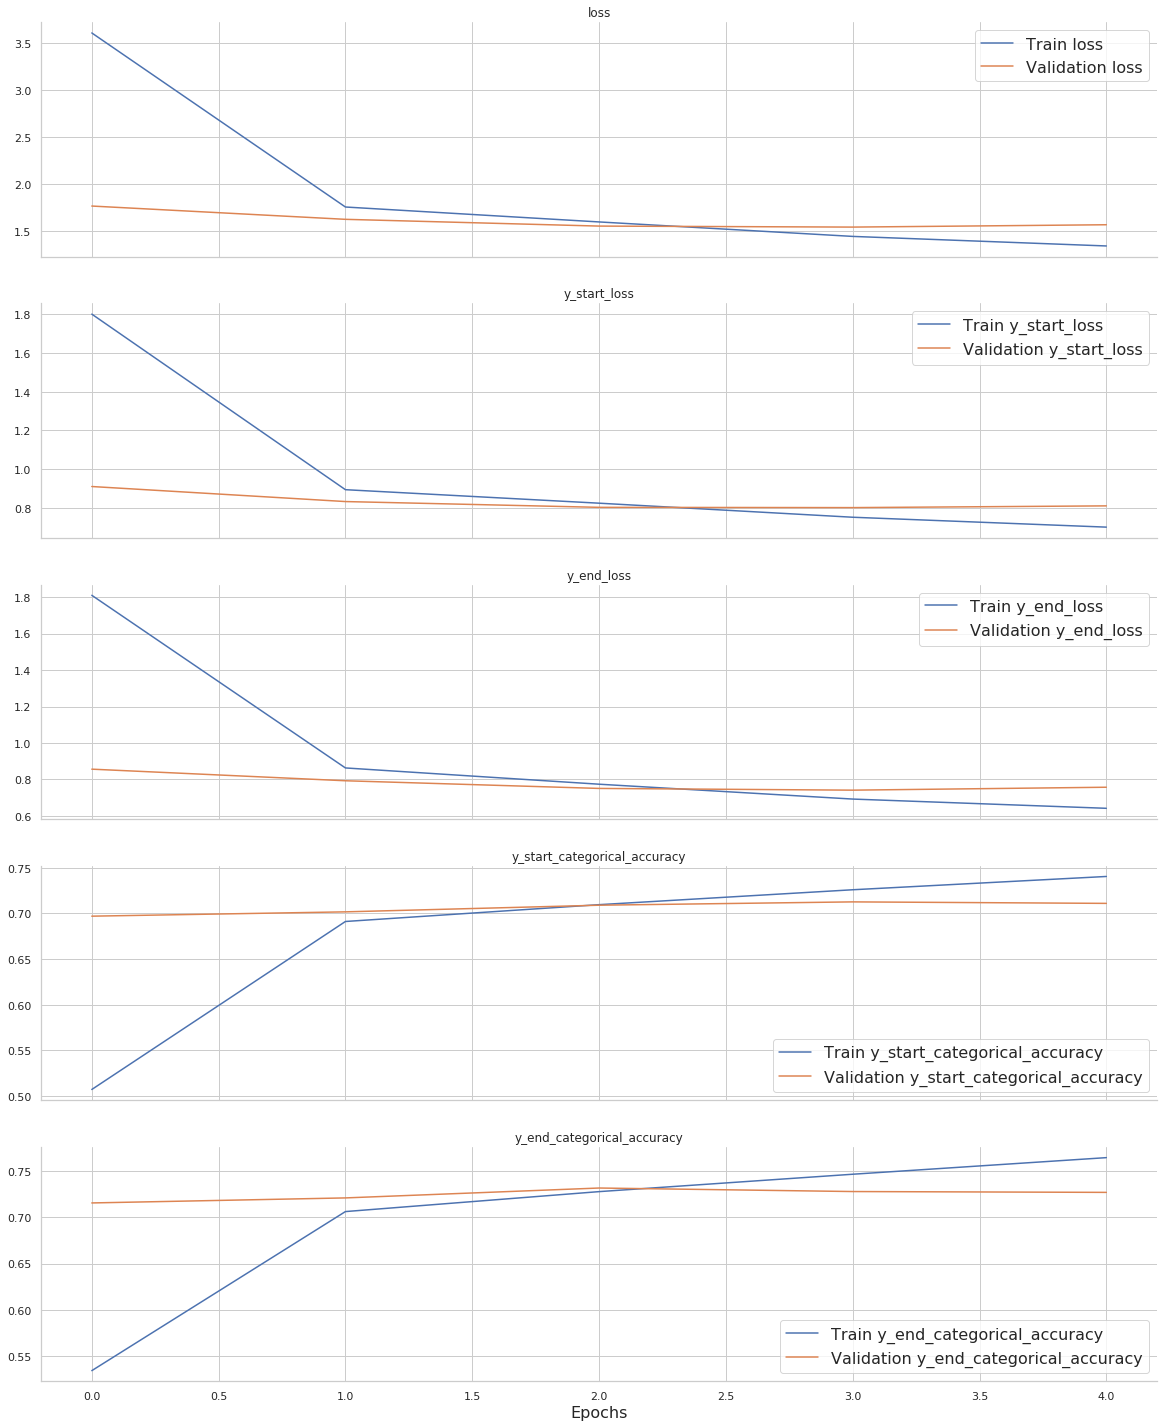

Fold: 2


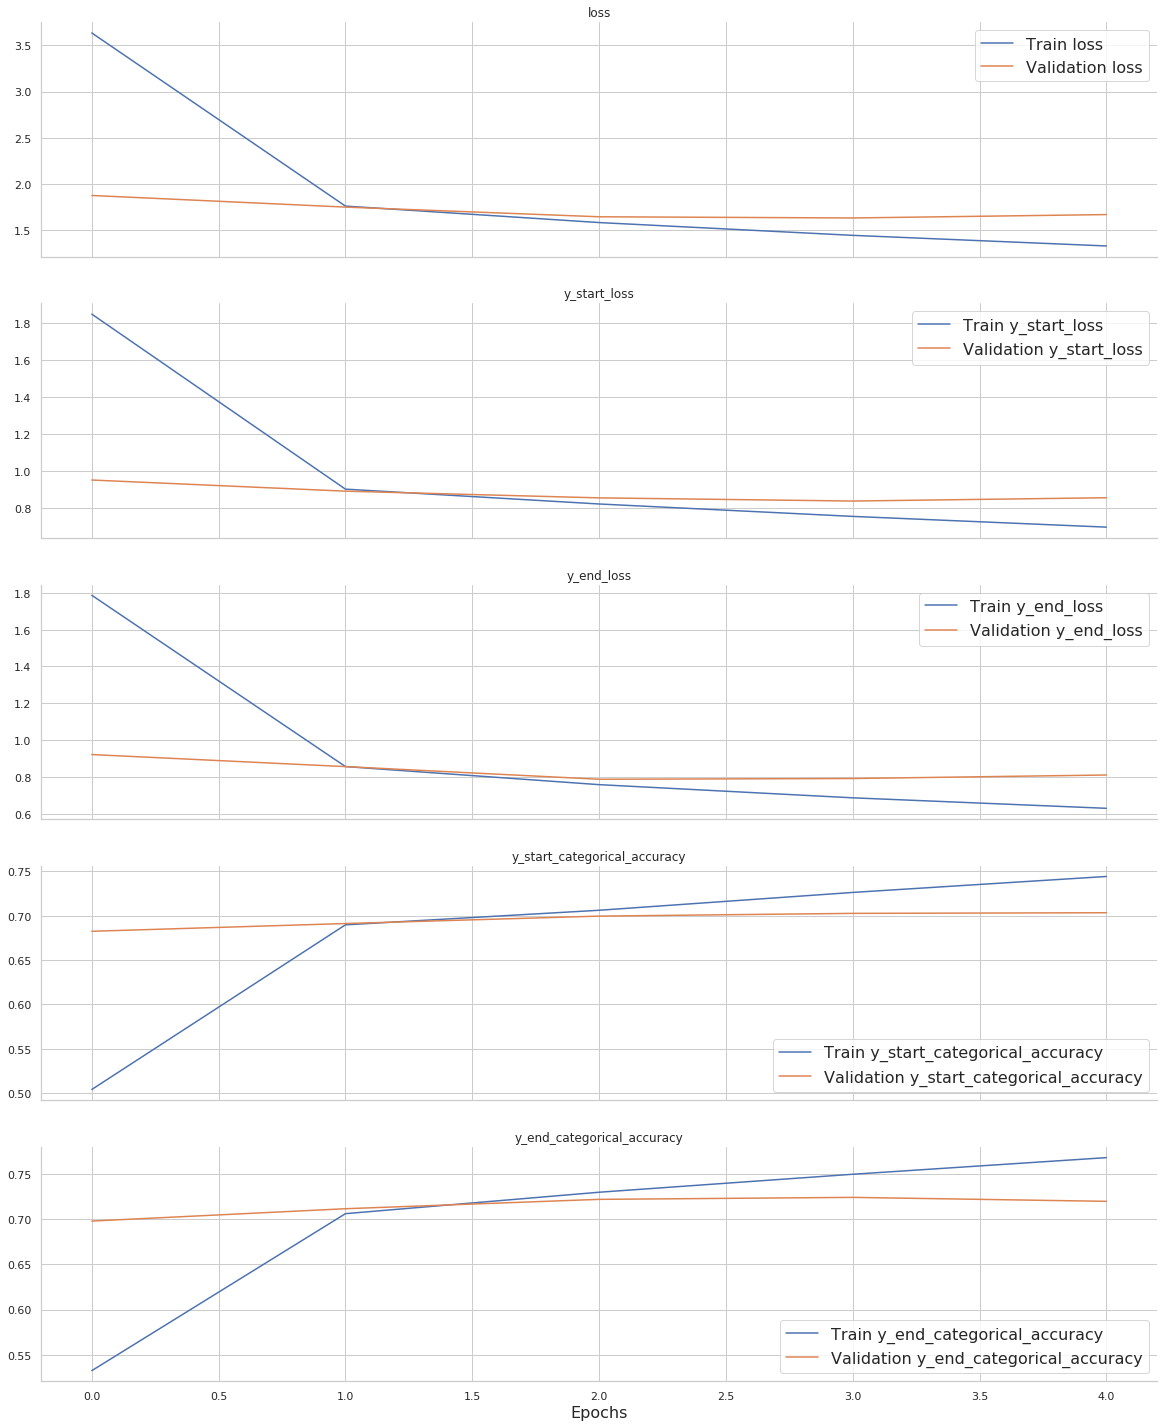

Fold: 3


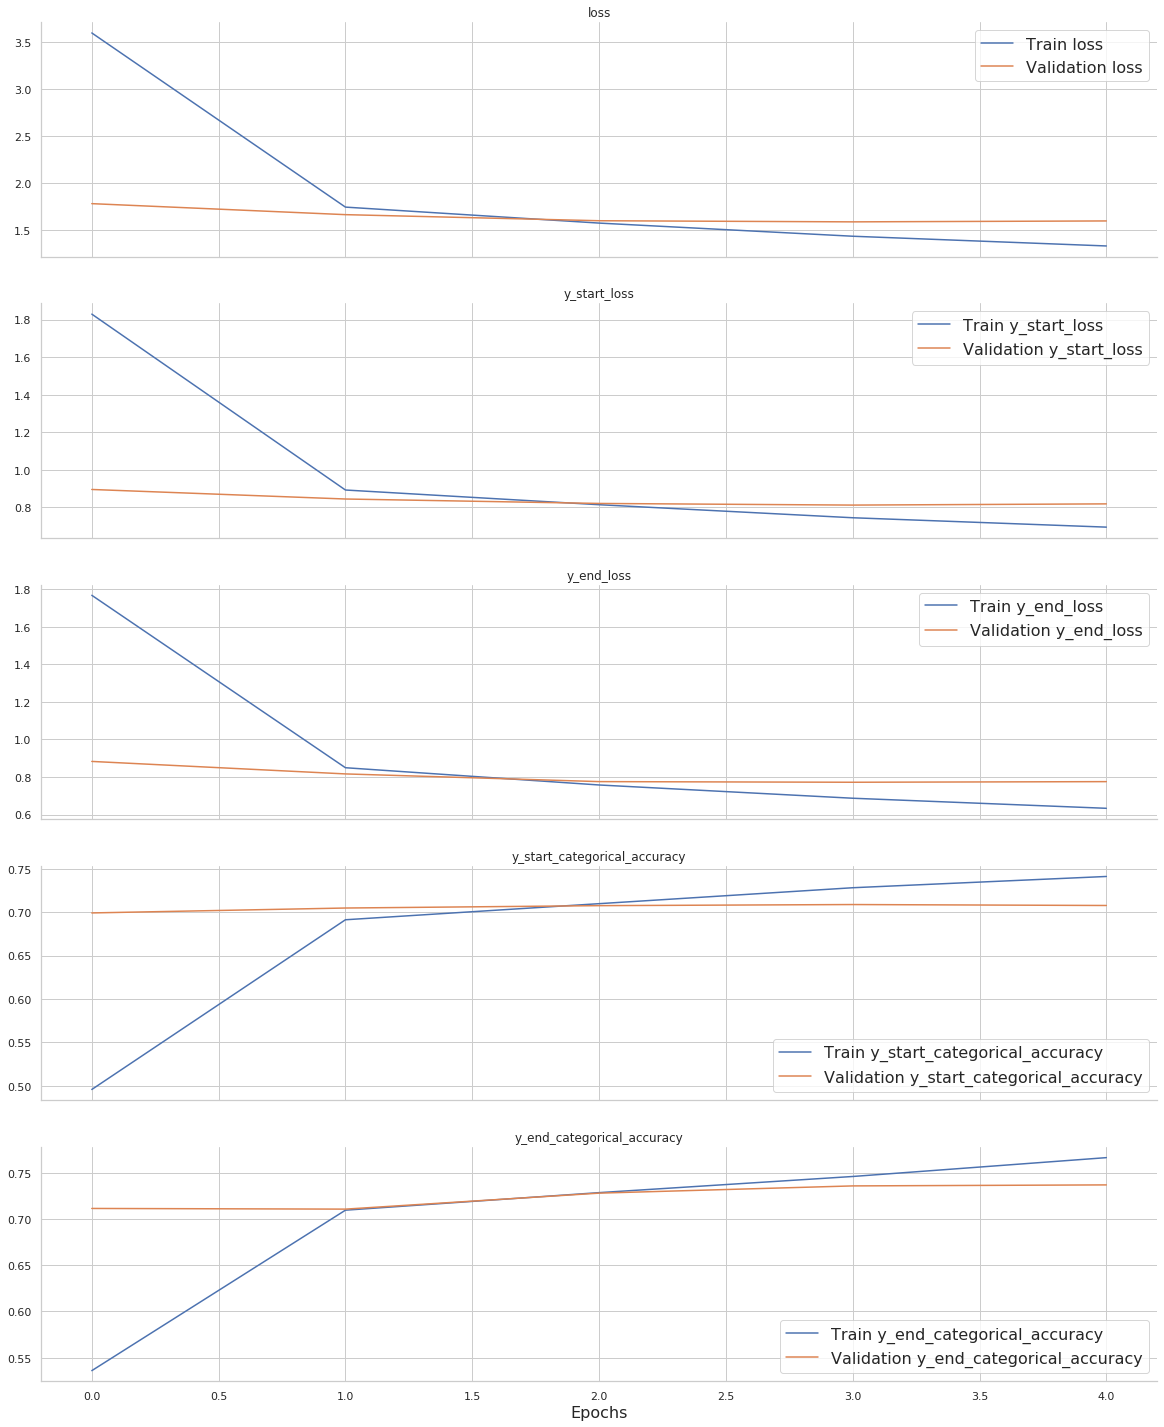

In [8]:
sns.set(style="whitegrid")
for n_fold in range(config['N_FOLDS']):
    print('Fold: %d' % (n_fold+1))
    plot_metrics(history_list[n_fold])

# Model evaluation

In [9]:
display(evaluate_model_kfold(k_fold, config['N_FOLDS']).style.applymap(color_map))

,Train,Valid,Var,Train_fold_1,Valid_fold_1,Train_fold_2,Valid_fold_2,Train_fold_3,Valid_fold_3
Metric/Jaccard,,,,,,,,,
Overall,0.751051,0.706018,0.045033,0.750748,0.706321,0.754053,0.703388,0.748351,0.708345
Sentiment neutral,0.974373,0.973366,0.001008,0.974305,0.973254,0.974683,0.972316,0.974133,0.974527
Sentiment negative,0.605902,0.521573,0.084330,0.603978,0.514799,0.613083,0.525926,0.600646,0.523994
Sentiment positive,0.593378,0.526860,0.066518,0.594261,0.534029,0.596098,0.515764,0.589775,0.530787
0 <= text wordCnt < 3,0.865428,0.852842,0.012585,0.862179,0.824627,0.869970,0.866446,0.864134,0.867454
3 <= text wordCnt < 10,0.798591,0.766172,0.032419,0.798171,0.755093,0.798327,0.769989,0.799275,0.773433
10 <= text wordCnt < 30,0.721541,0.669956,0.051585,0.721901,0.675286,0.726119,0.664323,0.716603,0.670258
30 <= text wordCnt < 100,0.695824,0.577226,0.118598,0.674005,0.663669,0.704604,0.520550,0.708862,0.547458
0 <= selected text wordCnt < 3,0.682504,0.602390,0.080114,0.725440,0.638927,0.673755,0.591226,0.648318,0.577018


# Visualize predictions

In [10]:
display(k_fold[[c for c in k_fold.columns if not (c.startswith('textID') or 
                                                  c.startswith('text_len') or 
                                                  c.startswith('selected_text_len') or 
                                                  c.startswith('text_wordCnt') or 
                                                  c.startswith('selected_text_wordCnt') or 
                                                  c.startswith('fold_') or 
                                                  c.startswith('start_fold_') or 
                                                  c.startswith('end_fold_'))]].head(15))

,text,selected_text,sentiment,prediction_fold_1,jaccard_fold_1,prediction_fold_2,jaccard_fold_2,prediction_fold_3,jaccard_fold_3
0,"i`d have responded, if i were going","i`d have responded, if i were going",neutral,"i`d have responded, if i were going",1.000000,"i`d have responded, if i were going",1.000000,"i`d have responded, if i were going",1.000000
1,sooo sad i will miss you here in san diego!!!,sooo sad,negative,sad,0.500000,sooo sad,1.000000,sooo sad,1.000000
2,my boss is bullying me...,bullying me,negative,bullying me...,0.333333,my boss is bullying me...,0.166667,my boss is bullying me...,0.166667
3,what interview! leave me alone,leave me alone,negative,leave me alone,1.000000,leave me alone,1.000000,leave me alone,1.000000
4,"sons of ****, why couldn`t they put them on th...","sons of ****,",negative,"****,",0.333333,"sons of ****,",1.000000,"sons of ****,",1.000000
5,http://www.dothebouncy.com/smf - some shameles...,http://www.dothebouncy.com/smf - some shameles...,neutral,http://www.dothebouncy.com/smf - some shameles...,1.000000,some shameless plugging for the best rangers f...,0.833333,some shameless plugging for the best rangers f...,0.833333
6,2am feedings for the baby are fun when he is a...,fun,positive,fun,1.000000,fun,1.000000,fun,1.000000
7,soooo high,soooo high,neutral,soooo high,1.000000,soooo high,1.000000,soooo high,1.000000
8,both of you,both of you,neutral,both of you,1.000000,both of you,1.000000,both of you,1.000000
9,journey!? wow... u just became cooler. hehe.....,wow... u just became cooler.,positive,wow...,0.200000,wow... u just became cooler.,1.000000,wow... u just became cooler.,1.000000
